<font size="5">To being analyzing TESS data, we first need to import some useful Python modules. Check comments for more details.</font>

In [2]:
#Needed for finding and organizing data downloaded externally from FFI filtergraph website. See HowToGetData.txt for more details.
import glob, os
from os import listdir
from os.path import isfile, join
import fnmatch


#Needed for making plots
import matplotlib.pyplot as plt
from matplotlib import pylab
from pylab import *
import matplotlib.gridspec as gridspec

#Needed for handling lists, arrays, strings, importing data and general math
import numpy as np
# import pandas as pd #optional (may be used in future)

#Needed for r
import astropy
from astropy.stats import BoxLeastSquares # <--- Super Important! We use this to search for periodic events in our data.
# print(astropy.__version__)
import lightkurve as lk #<--- Super Important! We use this to clean up our light curves as well as produce phase folded 
#                                              light curves based on our BLS models.

# Below is a custom definition to remove outliers in our light curves.
# This is a less aggresive approach than a standard 3*standard deviation
# cut that is commonly used. 
def ChauventsCriteron(x, y, z, mean=None, stdv=None):
    from scipy.special import erfc
    if mean is None:
        mean = y.mean()           # Mean of incoming array y
    if stdv is None:
        stdv = y.std()            # Its standard deviation
    N = len(y)                   # Lenght of incoming arrays
    criterion = 1.0/(2*N)        # Chauvenet's criterion
    d = abs(y-mean)/stdv         # Distance of a value to mean in stdv's
    d /= 2.0**0.5                # The left and right tail threshold values
    prob = erfc(d)               # Area normal dist.    
    filter = prob >= criterion   # The 'accept' filter array with booleans
    
    xf = x[filter]; yf = y[filter]; zf=z[filter]
#     print ("criterion: ", criterion)
#     print ("3*std:", std(y))
#     return filter                # Use boolean array outside this function
    return xf,yf,zf
# For some light curves, where there are flare events, we may need to 
# turn this off. (Will add in future versions)


#Below are some parameters we will use for cleaning up our data.
Nsig=3; bin_size=5; window_size=201;spacing=0.02

<font size="5">Next, we want to search our computer for our downloaded light curves from Filtergraph. See Getting_Started.txt for help.</font>

In [3]:
#Select your sector number. Here I choose 4:
SectorNumber=4 
print("TESS Sector",'{:02d}'.format(SectorNumber))

#------------------------------Finding Downloaded TESS Data Files --------------------------------------
# path = '/Users/felizd/Desktop/Felix/TESSdata/Sector'+str('{:02d}'.format(SectorNumber))+'/curves/clean' #location of where I put downloaded files
path = os.getcwd()+'/TESSdata/Sector'+str('{:02d}'.format(SectorNumber))+'/curves/clean' #####WORKS FOR MACS, CHECK FOR WINDOWS
data = [os.path.join(dirpath, f) # an array of path names to be looped over
    for dirpath, dirnames, files in os.walk(path) #recursively searches through directory
    for f in fnmatch.filter(files, '*.lc')] #finds every file (*) that ends with .lc

print ("number of files: ",len(data)) #number of files)


data.sort(key=lambda x: int(os.path.basename(x).split('_')[0])) #sorts them in alphanumeric order based on TIC ID

# for d in range(len(data)): # for full set (hundreds-thousands)
# for d in range(15):
#     print ("data set #", d+1 ," : ", data[d]) #I added the d+1 because python does zero-indexing (https://en.wikipedia.org/wiki/Zero-based_numbering)
#     print ("")

TESS Sector 04
number of files:  3051


<font size="5">Make sure data title is correct. This is pathname specific so depending on where you save your data, you may need to tweak your script. </font>

In [10]:
x = data[0] #selecting first file
print(x)
#splitting file name by first underscore and printing first term (TIC ID)
print ((os.path.basename(x).split)('_')[0]) 

# for d in range(15):
#     print (data[d])
#     print ("")

/Users/felizd/Desktop/Felix/TESSdata/Sector04/curves/clean/1025219_sector04_1_1.lc
1025219


filenumber 0
TIC 1025219_sector04_1_1
best period:  8.33
best T0:  0.8162268666666357


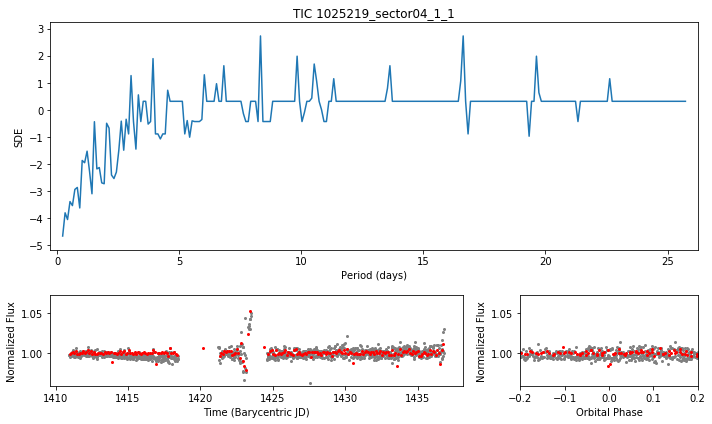


filenumber 1
TIC 1032938_sector04_1_1
best period:  8.33
best T0:  6.1149850000001305


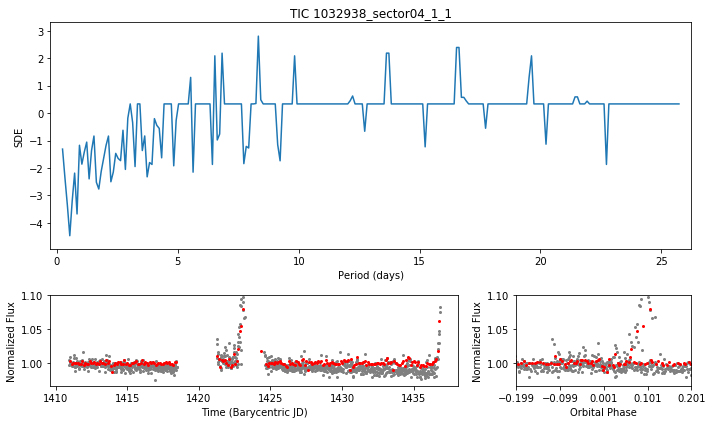


filenumber 3
TIC 4621226_sector04_1_1
best period:  0.23
best T0:  0.22956020000002592


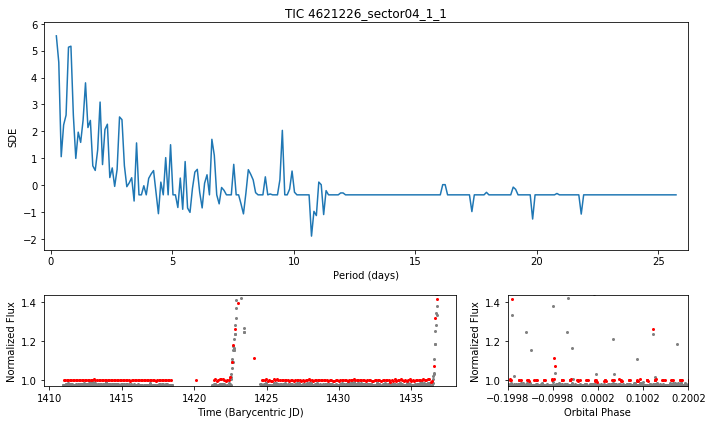


filenumber 5
TIC 4672641_sector04_1_1
best period:  13.930000000000001
best T0:  1.9416516666665053


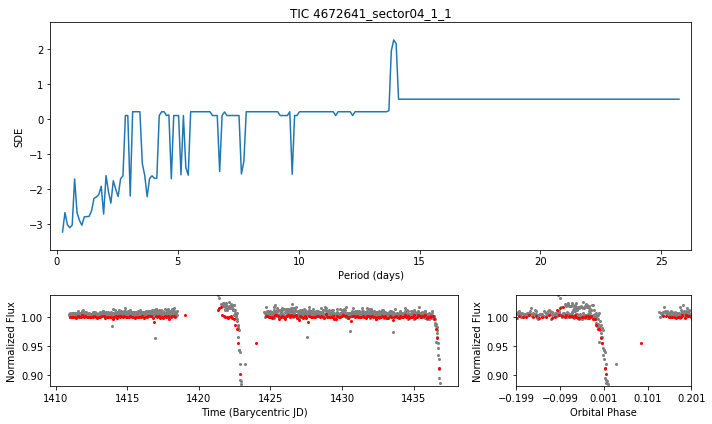


filenumber 8
TIC 4698255_sector04_1_1
best period:  13.830000000000002
best T0:  12.216651666666515


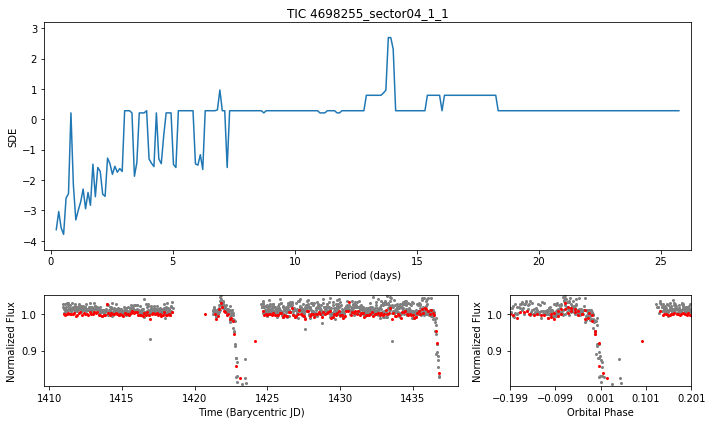

In [12]:
# for d in range(len(data)): #creating a for loop to show light curve figures for all files
for d in range(10): #creating a for loop to show light curve figures for all files    

    time     = np.transpose(np.loadtxt(data[d]))[0] #first  (zero indexing in python) column 
    mag      = np.transpose(np.loadtxt(data[d]))[1] #second (zero indexing in python) column 
    magerror = np.transpose(np.loadtxt(data[d]))[2] #third (zero indexing in python) column 
    
    mask = np.where(np.isnan(mag)==False)[0] #creating array of only real numbers by setting np.isnan(mag)==False. 
    time = time[mask]                        #Sometimes there are holes in data filled with NaNs
    mag = mag[mask]
    magerror = magerror[mask]
    
    flux = 10.0**(mag/-2.5)/np.mean(10.0**(mag/-2.5))
    fluxerror = flux*(10.0**(magerror/2.5)-1.0)
    
    #removing outliers with Chauvenet's criterion
    t2,f2,fe2 = ChauventsCriteron(time,flux,fluxerror)
    lc = lk.LightCurve(t2,f2,fe2)
    detrended_lc = lc.flatten(window_length=window_size).bin(binsize=bin_size)
    
    
    #detrending
#     lc = lk.LightCurve(time,flux,fluxerror)
#     detrended_lc = lc.flatten(window_length=window_size).bin(binsize=bin_size).remove_outliers(sigma=Nsig,iters=None)
    
    #doing BLS search:
    bls = BoxLeastSquares(detrended_lc.time, detrended_lc.flux, detrended_lc.flux_err)
    periods = np.arange(0.23, (max(detrended_lc.time)-min(detrended_lc.time)), 0.1)
    durations = np.arange((1.0/24.0), (5.0/24.0), 0.1) #1 hr to 5 hrs
    periodogram = bls.power(periods, durations,objective='snr')
    
    #phase folding with best BLS model
    index = np.argmax(periodogram.power); #print(index)
    best_period = periodogram.period[index]; 
    best_t0 = periodogram.transit_time[index];
    detrendedphasefoldedlc = [detrended_lc.fold(period=best_period,t0=best_t0).phase,detrended_lc.fold(period=best_period,t0=best_t0).flux, detrended_lc.fold(period=best_period,t0=best_t0).flux_err]
    phasefoldedlc = [lc.fold(period=best_period,t0=best_t0).phase,lc.fold(period=best_period,t0=best_t0).flux, lc.fold(period=best_period,t0=best_t0).flux_err]

       
    SDE = (periodogram.power - np.mean(periodogram.power))/np.std(periodogram.power)
    cutoff_threshold=2.0
    
    if len(np.where(SDE>cutoff_threshold)[0])>0:
        print("filenumber",d)
        print("TIC", data[d][59:-3])
        print("best period: ", best_period)
        print("best T0: ",best_t0)

        gs1 = gridspec.GridSpec(3, 3)
        gs1.update(left=0.65, right=1.25, wspace=0.25,hspace=0.5)


        f = plt.figure(figsize=(10,6))
        ax1 = f.add_subplot(gs1[:-1, :])
        ax2 = f.add_subplot(gs1[-1, :-1])
        ax3 = f.add_subplot(gs1[-1, -1])


    #     ax1.plot(periodogram.period, periodogram.power, rasterized=True) 
        ax1.plot(periodogram.period, SDE, rasterized=True) 
        plt.xticks(np.arange(0.0, 31.0, 1.0))
        ax1.set_title("TIC "+ data[d][59:-3])
        ax1.set_xlabel("Period (days)")
        ax1.set_xlim(np.min(periodogram.period)-0.5, np.max(periodogram.period)+0.5)
    #     ax1.set_ylabel("BLS Power SNR")
        ax1.set_ylabel("SDE")
    #     ax1.set_ylim(np.min(periodogram.power)-0.5, np.max(periodogram.power)+0.5)
        ax1.set_ylim(np.min(SDE)-0.5, np.max(SDE)+0.5)

        ax2.plot(detrended_lc.time,detrended_lc.flux,c='red',markersize=4,marker='.',linestyle='none',zorder=1,label='detrended: windowsize: '+str(window_size)+", binsize: "+str(bin_size)+", Nsig: "+str(Nsig))
        ax2.plot(time,flux,c='grey',marker='.',markersize=4,linestyle='none',zorder=0,label='undetrended')
    #     ax2.legend(loc='upper right')
    #     ax2.set_ylim(0.985,1.015)
        ax2.set_ylim(np.min(detrended_lc.flux)-spacing, np.max(detrended_lc.flux)+spacing)
        ax2.set_xlabel("Time (Barycentric JD)")
        ax2.set_ylabel("Normalized Flux") 

        ax3.plot(detrendedphasefoldedlc[0],detrendedphasefoldedlc[1],c='red',markersize=4,marker='.',linestyle='none',zorder=1,label='detrended: windowsize: '+str(window_size)+", binsize: "+str(bin_size)+", Nsig: "+str(Nsig))
        ax3.plot(phasefoldedlc[0],phasefoldedlc[1],c='grey',marker='.',markersize=4,linestyle='none',zorder=0,label='undetrended')
    #     ax3.legend(loc='upper right')
        ax3.set_xlabel("Orbital Phase")
        ax3.set_ylabel("Normalized Flux") 
    #     ax3.set_ylim(0.985,1.015)
        ax3.set_ylim(np.min(detrended_lc.flux)-spacing, np.max(detrended_lc.flux)+spacing)
        ax3.set_xticks(np.arange(np.min(phasefoldedlc[0]),np.max(phasefoldedlc[0])+0.1,0.1))
        ax3.set_xlim(-0.2,0.2)
        gs1.tight_layout(f)

        plt.savefig(path[:-13]+"/plots/"+str(data[d][59:-3])+".png", dpi=400, rasterized=True,bbox_inches='tight')        
        plt.show()    
        print( "") #adds space between figures
    else:
        continue
        print( "") #adds space between figures